# Basic simulation technique for arbitrary linear parity check code

This routine generates a quantum circuit based on a given parity check matrix, adds the noise-model which we were using before and samples this circuit for different physical error parameters. Syndromes are decoded by belief propagation corrected and compared to the initial generated state. This provides a basic benchmarking script, there is no optimization for local 2-qubit operations and no optimization for "good" LDPC codes.

In [14]:
import stim
import pymatching
import matplotlib.pyplot as plt
import numpy as np
from ldpc import BpDecoder


def count_logical_errors(H, p, circuit: stim.Circuit, num_shots: int) -> int:
    sampler = circuit.compile_detector_sampler()
    dets, obs = sampler.sample(num_shots, separate_observables=True)
    syndrome_bits = dets.astype(np.uint8)

    # LDPC Belief propagation decoder
    bpd = BpDecoder(
        H, 
        error_rate=float(p), 
        max_iter=30,
        bp_method="product_sum",
    )
    corrrection_vectors = np.zeros([syndrome_bits.shape[0], H.shape[1]], dtype=np.uint8) 
    for i, syndrome in enumerate(syndrome_bits):
        corrrection_vectors[i] = bpd.decode(syndrome)

    output = np.mod(obs.astype(np.uint8) + corrrection_vectors,2)
    n_correct = np.sum(np.all(output == 0, axis=1))
    n_logical_errors = num_shots - n_correct
    return n_logical_errors


def LDPC_stabilizer_circuit(p, H):
    c = stim.Circuit()

    # H.shape[1] data qubits
    # H.shape[0] ancillas
    data = list(range(H.shape[1]))
    anc = list((range(H.shape[1], H.shape[1] + H.shape[0])))

    # Initialize
    c.append("R", data + anc)

    # X noise on data
    c.append("X_ERROR", data, p)

    # Implement stabilizer measurements based on given parity matrix H
    for i, anc_qubit in enumerate(anc):
        for q in np.flatnonzero(H[i, :]):
            c.append("CNOT", [q, anc_qubit])
        c.append("M", anc_qubit)
        c.append("DETECTOR", [stim.target_rec(-1)])

    # Measure data
    c.append("M", data)

    # Observables for data qubits
    counter=0
    for i in reversed(range(1, len(data)+1)):
        c.append(
            "OBSERVABLE_INCLUDE",
            [stim.target_rec(-i)],
            counter
        )
        counter+=1
    
    return c

def run_sim(H, p, num_shots):
    c = LDPC_stabilizer_circuit(p = p, H = H.toarray())
    # c.diagram('timeline-svg')
    num_logical_errors = count_logical_errors(H.toarray(), p, c, num_shots)
    p_L = num_logical_errors / num_shots
    return p_L
    


In [17]:
import itertools
from ldpc import codes

error_probabilities = np.logspace(-1, np.log10(0.5), 21)
num_shots = 1000

data = {}
counter = 0
for n in range(50, 200, 50):
    data[n] = []
    print(counter)
    for p in error_probabilities: 
        H = codes.random_binary_code(n, n//4, 4, 0, 0.2)
        data[n].append(run_sim(H, p, num_shots))
    counter += 1

0
1
2


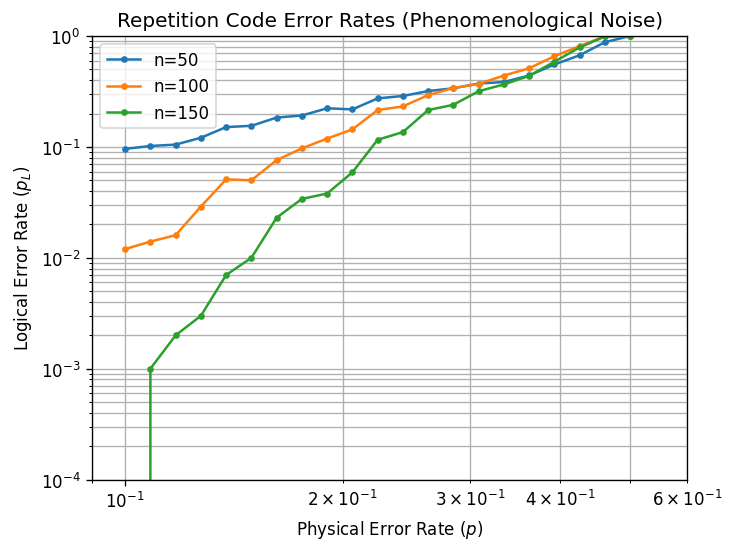

In [19]:
# plot results
fig, ax = plt.subplots(1, 1)
for n, pL_list in data.items():
    ax.loglog(error_probabilities, pL_list, "o-", label=f"n={n}", markersize=3)
ax.set_ylim(1e-4, 1e-0)
ax.set_xlim(9e-2, 6e-1)
ax.loglog()
ax.set_title("Repetition Code Error Rates (Phenomenological Noise)")
ax.set_xlabel("Physical Error Rate ($p$)")
ax.set_ylabel("Logical Error Rate ($p_L$)")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger